In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out import create_dir
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.point_clouds.ae_templates import conv_architecture_ala_nips_17, default_train_params_ala_nips_17
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry, decoder_with_fc_only
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet

from tf_lab.in_out.basics import Data_Splitter
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_points = 2048
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
top_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_points))

In [6]:
# train_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_small_size_splits/train.txt')
# val_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_small_size_splits/val.txt')
train_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/train.txt')
val_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/val.txt')

In [7]:
do_training = True
load_pretrained_model = False
load_epoch = None
random_seed = 42
splitter = Data_Splitter(top_pclouds_path, data_file_ending='.ply', random_seed=42)

In [8]:
bneck_size = 256
loss = 'chamfer'
experiment_id = '1'

In [9]:
experiment_name = '_'.join(['chair_85_5_10', 'exp', experiment_id, str(n_pc_points),
                            'pts_bneck', str(bneck_size), loss
                           ])

train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/testing_ae_settings', experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/chair_85_5_10_exp_1_2048_pts_bneck_256_chamfer'

In [10]:
tr_files = splitter.load_splits(train_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(tr_files, n_threads=20, loader=snc_loader, verbose=True)
train_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)

val_files = splitter.load_splits(val_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(val_files, n_threads=20, loader=snc_loader, verbose=True)
val_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)

5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [11]:
def architectures_to_test(bneck, bnorm, neighborhood):
    res = dict()

    res['encoder_args'] = {'filter_sizes': [neighborhood, min(neighborhood, 20), 10, 5],
                           'n_filters': [64, 128, 256, bneck],
                           'strides': [1, 1, 2, 2],
                           'b_norm': bnorm
                          }
    
    res['decoder_args'] = {'layer_sizes': [1024, 2048, 6144],
                           'b_norm': bnorm
                          }
    return res

In [12]:
arc_param = architectures_to_test(bneck_size, False, 20)

In [13]:
if load_pretrained_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
    if conf.train_dir != train_dir:
        conf.train_dir = train_dir
    conf.save(osp.join(train_dir, 'configuration'))
else:
    conf = Conf(
                n_input = [n_pc_points, 3],
                loss = loss,
                training_epochs = 100,
                batch_size = 50,
                denoising = False,
                learning_rate = 0.0005,
                train_dir = train_dir,             
                loss_display_step = 1,
                saver_step = 10,
                z_rotate = False,
                encoder = encoder_with_convs_and_symmetry,
                decoder = decoder_with_fc_only,
                encoder_args = arc_param['encoder_args'],
                decoder_args = arc_param['decoder_args'],
               )
    
    conf.experiment_name = experiment_name
    conf.held_out_step = 5
    conf.save(osp.join(conf.train_dir, 'configuration'))

In [14]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)

In [15]:
if load_pretrained_model:
    if load_epoch is None: # load last saved.
        saved_epochs = read_saved_epochs(conf.train_dir)
        load_epoch = saved_epochs[-1]        
    ae.restore_model(conf.train_dir, load_epoch, verbose=True)

In [16]:
if do_training:
    buf_size = 1 # flush each line
    fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)    
    train_stats = ae.train(train_data, conf, log_file=fout, held_out_data=val_data)
    fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.1813', 'loss=', '0.003948789')
INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/chair_85_5_10_exp_1_2048_pts_bneck_256_chamfer/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/chair_85_5_10_exp_1_2048_pts_bneck_256_chamfer/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0002', 'training time (minutes)=', '0.1521', 'loss=', '0.002167256')
('Epoch:', '0003', 'training time (minutes)=', '0.1530', 'loss=', '0.001922447')
('Epoch:', '0004', 'training time (minutes)=', '0.1430', 'loss=', '0.001653937')
('Epoch:', '0005', 'training time (minutes)=', '0.1513', 'loss=', '0.001492948')
('Held Out Data :', 'forward time (minutes)=', '0.0021', 'loss=', '0.001547034')
('Epoch:', '0006', 'training time (minutes)=', '0.1464', 'loss=', '0.001395727')
('Epoch:', '0007', 'training time (minutes)=', '0.1521', 'loss=', '0.001294245')
('Epoch:', '0008', 'training time (minutes)=', '0.1641', 'loss=', '0.001218458')
('Epoch:', '0009', 'training time (minutes)=', '0.1638', 'loss=', '0.001148146')
('Epoch:', '0010', 'training time (minutes)=', '0.1839', 'loss=', '0.001091290')
INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/chair_85_5_10_exp_1_2048_pts_bneck_256_chamfer/models.ckpt-10 is not in all_model_checkpoint_paths. Ma

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/chair_85_5_10_exp_1_2048_pts_bneck_256_chamfer/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0030', 'loss=', '0.001227272')
('Epoch:', '0011', 'training time (minutes)=', '0.1606', 'loss=', '0.001049436')
('Epoch:', '0012', 'training time (minutes)=', '0.1726', 'loss=', '0.001013013')
('Epoch:', '0013', 'training time (minutes)=', '0.1804', 'loss=', '0.000980130')
('Epoch:', '0014', 'training time (minutes)=', '0.1798', 'loss=', '0.000949570')
('Epoch:', '0015', 'training time (minutes)=', '0.1672', 'loss=', '0.000918255')
('Held Out Data :', 'forward time (minutes)=', '0.0041', 'loss=', '0.001134366')
('Epoch:', '0016', 'training time (minutes)=', '0.1797', 'loss=', '0.000882714')
('Epoch:', '0017', 'training time (minutes)=', '0.1732', 'loss=', '0.000878912')
('Epoch:', '0018', 'training time (minutes)=', '0.1673', 'loss=', '0.000843597')
('Epoch:', '0019', 'training time (minutes)=', '0.1677', 'loss=', '0.000851628')
('Epoch:', '0020', 'training time (minutes)=', '0.1547', 'loss=', '0.000812664')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/chair_85_5_10_exp_1_2048_pts_bneck_256_chamfer/models.ckpt-20 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0020', 'loss=', '0.001100904')
('Epoch:', '0021', 'training time (minutes)=', '0.1809', 'loss=', '0.000787266')


UnboundLocalError: local variable 'recon' referenced before assignment

In [144]:
from tf_lab.fundamentals.utils import count_cmp_to_value
from tf_lab.external.Chamfer_EMD_losses.tf_nndistance import nn_distance
from general_tools.simpletons import iterate_in_chunks

In [145]:
def accuracy_coverage(predict_pclouds, gt_pclouds, bound_val=0.02, batch_size=100, sess=None):
    if sess is None:
        sess = tf.Session()
        
    n_clouds, n_points_a, dim = predict_pclouds.shape
    _, n_points_b, _ = gt_pclouds.shape
        
    pc_a = tf.placeholder(tf.float32, shape=(None, n_points_a, dim))
    pc_b = tf.placeholder(tf.float32, shape=(None, n_points_b, dim))

    cost_a_to_b, _, cost_b_to_a, _ = nn_distance(pc_a, pc_b)
    cost_a_to_b = tf.sqrt(cost_a_to_b)
    cost_b_to_a = tf.sqrt(cost_b_to_a)
    
    accuracy = count_cmp_to_value(cost_a_to_b, bound_val, comparator=tf.less_equal, axis=1)
    accuracy /= n_points_a
    
    coverage = count_cmp_to_value(cost_b_to_a, bound_val, comparator=tf.less_equal, axis=1)
    coverage /= n_points_b
    
    idx = np.arange(n_clouds)
    accs = []
    covs = []
    for b in iterate_in_chunks(idx, batch_size):
        feed = {pc_a: predict_pclouds[b], pc_b: gt_pclouds[b]}
        acc_b, cov_b = sess.run([accuracy, coverage], feed_dict = feed)
        accs.append(acc_b)
        covs.append(cov_b)
    return np.hstack(accs), np.hstack(covs)

In [134]:
some_pcs = train_data.next_batch(1000)[0]
a, b = accuracy_coverage(some_pcs, ae.reconstruct(some_pcs)[0])

In [135]:
np.median(a), np.median(b)

(0.68652344, 0.77441406)

In [146]:
sess = tf.Session()

In [147]:
sess.close()

In [136]:
from pc_completions.evaluation import basic_comletion_measures

In [137]:
aa, bb, _ = basic_comletion_measures(some_pcs, ae.reconstruct(some_pcs)[0])

Medians of Accuracy=0.687, Coverage=  1, H-mean=  1.


In [138]:
np.median(aa), np.median(bb)

(0.6865234375, 0.7744140625)

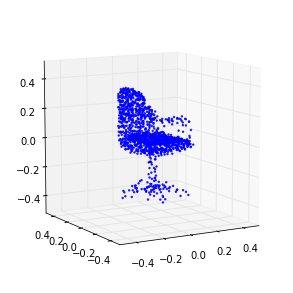

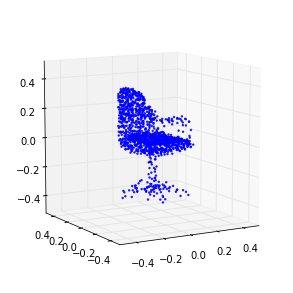

In [97]:
Point_Cloud(ae.reconstruct(train_data.next_batch(1)[0])[0][0]).plot()